# 1. Model Profit Benchmarking

**Goal:** Compare Logistic Regression, Random Forest, and XGBoost not on accuracy, but on **Total Profit**.

**Business Context:**
- **True Negative (Good Payer):** +$1,000
- **False Negative (Default):** -$5,000
- **False Positive:** $0
- **True Positive:** $0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

df = pd.read_excel('../data/raw/credit_card_default.xls', header=1)
df.rename(columns={'default payment next month': 'target'}, inplace=True)
X = df.drop(['ID', 'target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 1. Define Profit Metric

Custom scorer for model evaluation.

In [2]:
cost_matrix = {'TN': 1000, 'FP': 0, 'FN': -5000, 'TP': 0}

def calculate_total_profit(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (tn * cost_matrix['TN']) + (fp * cost_matrix['FP']) + (fn * cost_matrix['FN']) + (tp * cost_matrix['TP'])

# Note: Standard classifiers use 0.5 threshold. We will optimize this later.
# For benchmarking, we will just see who has best Probabilities (ROC-AUC) closely followed by profit potential.

## 2. Multi-Model Comparison

We train 3 models and calculate their Max Potential Profit on the test set.

In [3]:
models = {
    'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))]),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Find optimal threshold for THIS model
    thresholds = np.linspace(0, 1, 100)
    profits = [calculate_total_profit(y_test, (y_probs >= t).astype(int)) for t in thresholds]
    max_profit = np.max(profits)
    best_thresh = thresholds[np.argmax(profits)]
    
    results.append({'Model': name, 'Max Profit': max_profit, 'Optimal Threshold': best_thresh})

res_df = pd.DataFrame(results).sort_values('Max Profit', ascending=False)
display(res_df)

Training Logistic Regression...


Training Random Forest...


Training XGBoost...


C:\Users\Ravikiran Bhonagiri\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [18:01:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Max Profit,Optimal Threshold
2,XGBoost,1168000,0.151515
1,Random Forest,1041000,0.212121
0,Logistic Regression,801000,0.252525


## 3. Visualization

Which model makes us the most money?

C:\Users\Ravikiran Bhonagiri\AppData\Local\Temp\ipykernel_5708\1350602814.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Max Profit', data=res_df, palette='viridis')


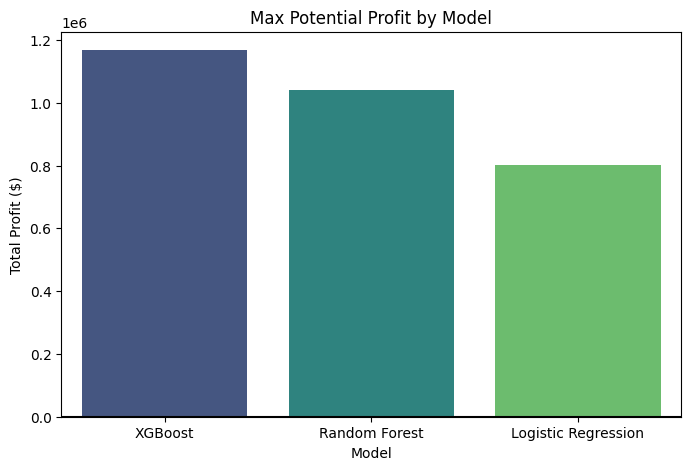

In [4]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Max Profit', data=res_df, palette='viridis')
plt.title('Max Potential Profit by Model')
plt.ylabel('Total Profit ($)')
plt.axhline(0, color='black')
plt.show()